In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
!wget -q www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

In [3]:
!tar -xvf spark-2.4.5-bin-hadoop2.7.tgz

spark-2.4.5-bin-hadoop2.7/
spark-2.4.5-bin-hadoop2.7/licenses/
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-jtransforms.html
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-zstd.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-zstd-jni.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-xmlenc.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-vis.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-spire.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-sorttable.js.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-slf4j.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-scopt.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-scala.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-sbt-launch-lib.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-respond.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-reflectasm.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-pyrolite.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-py4j.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-protobuf.txt
spark-2.4.5-bin-hadoop2.7/licenses/LICENSE-pmml-model

In [0]:
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

# Сложный вариант

In [7]:
data = spark.read.csv('Titanik.csv', inferSchema=True, header=True)
cols = data.columns
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [8]:
data.take(2)

[Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S'),
 Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C')]

In [9]:
data2 = spark.read.csv('Titanik2.csv', inferSchema=True, header=True)
cols = data2.columns
data2.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Embarked: string (nullable = true)



In [10]:
data2.take(2)

[Row(PassengerId=1, Survived=0, Pclass=3, Fare=7.25, Sex='male', Age=22.0, Embarked='S'),
 Row(PassengerId=2, Survived=1, Pclass=1, Fare=71.2833, Sex='female', Age=38.0, Embarked='C')]

In [0]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['Sex', 'Embarked']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Survived', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['PassengerId', 'Pclass', 'Age','Fare']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [12]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data2)
data2 = pipelineModel.transform(data2)
selectedCols = ['label', 'features'] + cols
data2 = data2.select(selectedCols)
data2.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Embarked: string (nullable = true)



In [13]:
data2.show()

+-----+--------------------+-----------+--------+------+-------+------+----+--------+
|label|            features|PassengerId|Survived|Pclass|   Fare|   Sex| Age|Embarked|
+-----+--------------------+-----------+--------+------+-------+------+----+--------+
|  0.0|[1.0,1.0,0.0,1.0,...|          1|       0|     3|   7.25|  male|22.0|       S|
|  1.0|[0.0,0.0,1.0,2.0,...|          2|       1|     1|71.2833|female|38.0|       C|
|  1.0|[0.0,1.0,0.0,3.0,...|          3|       1|     3|  7.925|female|26.0|       S|
|  1.0|[0.0,1.0,0.0,4.0,...|          4|       1|     1|   53.1|female|35.0|       S|
|  0.0|[1.0,1.0,0.0,5.0,...|          5|       0|     3|   8.05|  male|35.0|       S|
|  0.0|[1.0,1.0,0.0,7.0,...|          7|       0|     1|51.8625|  male|54.0|       S|
|  0.0|[1.0,1.0,0.0,8.0,...|          8|       0|     3| 21.075|  male| 2.0|       S|
|  1.0|[0.0,1.0,0.0,9.0,...|          9|       1|     3|11.1333|female|27.0|       S|
|  1.0|[0.0,0.0,1.0,10.0...|         10|       1|     

In [14]:
train, test = data2.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 503
Test Dataset Count: 209


In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

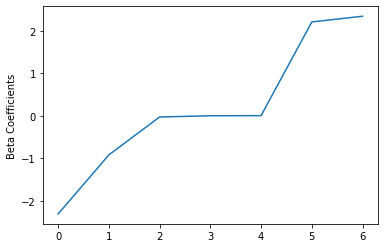

In [16]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

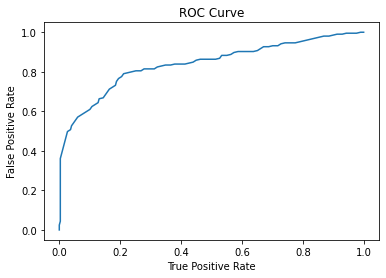

Training set areaUnderROC: 0.8391717138647898


In [17]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

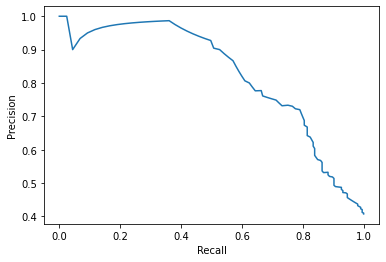

In [18]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [19]:
predictions = lrModel.transform(test)
predictions.show(10)

+-----+--------------------+-----------+--------+------+------+------+----+--------+--------------------+--------------------+----------+
|label|            features|PassengerId|Survived|Pclass|  Fare|   Sex| Age|Embarked|       rawPrediction|         probability|prediction|
+-----+--------------------+-----------+--------+------+------+------+----+--------+--------------------+--------------------+----------+
|  0.0|[0.0,0.0,0.0,768....|        768|       0|     3|  7.75|female|30.5|       Q|[1.76807278128914...|[0.85421783884845...|       0.0|
|  0.0|[0.0,0.0,0.0,886....|        886|       0|     3|29.125|female|39.0|       Q|[1.82700283626983...|[0.86140429206460...|       0.0|
|  0.0|[0.0,1.0,0.0,19.0...|         19|       0|     3|  18.0|female|31.0|       S|[0.16558026012148...|[0.54130074684974...|       0.0|
|  0.0|[0.0,1.0,0.0,101....|        101|       0|     3|7.8958|female|28.0|       S|[0.05055282938997...|[0.51263551653031...|       0.0|
|  0.0|[0.0,1.0,0.0,133....|      

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8556129279020843


In [21]:
data3 = data2
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data3)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data3)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data3.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|[0.0,0.0,0.0,658....|
|           1.0|  0.0|[0.0,0.0,1.0,178....|
|           0.0|  0.0|[0.0,1.0,0.0,39.0...|
|           0.0|  0.0|[0.0,1.0,0.0,101....|
|           1.0|  0.0|[0.0,1.0,0.0,206....|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0.202765
RandomForestClassificationModel (uid=RandomForestClassifier_9540385a4311) with 10 trees


In [25]:
inputData = data2
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# generate the train/test split.
(train, test) = inputData.randomSplit([0.8, 0.2])

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.178808
